In [1]:
from common_imports import *
from helper import *

# To plot pretty figures
%matplotlib widget

Using TensorFlow backend.


1.13.1


### Train a DNN on the modified dataset

Creating data...


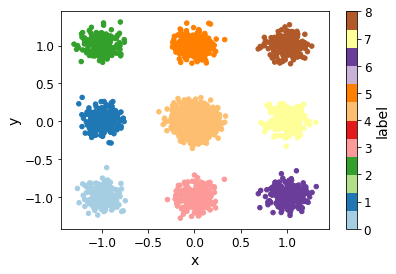

Train Size: (1800, 2)
Test Size: (200,)
Categories: [array([0, 1])]


In [2]:
# Get split returns a generator
# List comprehension is one way to evaluate a generator

original_data, modded_samples, training_labels, original_labels = simulate_blobs(class_size=2000)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_test, y_test, y_original, X_valid, y_valid, y_valid_original = get_train_test_val(modded_samples, original_labels, training_labels)


print("Train Size:", X_train.shape)
print("Test Size:", y_test.shape)


hot_encoder = dfHotEncoder()
hot_encoder.fit(training_labels)
print("Categories:", hot_encoder.categories_)

In [3]:
NUM_FEATURES = X_train.shape[1]
NUM_LABELS = len(hot_encoder.categories_[0])

In [26]:
def build_dnn(num_features, num_labels=3):

#     reset_graph()
    
    keras.backend.clear_session()

    nn = keras.models.Sequential()
    Dense = keras.layers.Dense
    
    # Using He initialization
    he_init = tf.keras.initializers.he_uniform()
    
    nn.add(Dense(units = 16, activation="elu", input_dim=num_features,
                kernel_initializer=he_init))
    nn.add(Dense(units = 16, activation="elu",
                kernel_initializer=he_init))
#     nn.add(Dense(units = 16, activation="elu",
#                 kernel_initializer=he_init))
    nn.add(Dense(units=2, activation= "softmax",
                kernel_initializer=he_init))

#     BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    nn.compile(loss="categorical_crossentropy",
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    return nn

def train_model(model, X, y, X_test=[], y_test=[], epochs=30, batch_size=20, verbose=1, plot=True):
    
    ZScaler = StandardScaler().fit(X)
    
    X_train = ZScaler.transform(X)
    X_test = ZScaler.transform(X_test)
    
    y_train = hot_encoder.transform(y)
    y_test = hot_encoder.transform(y_test)
    
#     lr_scheduler = keras.callbacks.LearningRateScheduler(exp_decay)
    callback_list = []
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size,
                        validation_data=(X_test, y_test), callbacks=callback_list, verbose=verbose)
    
#     if plot: plot_history(history)
    
    return history, ZScaler


In [27]:
nn = build_dnn(NUM_FEATURES)
%time history, Zscaler = train_model(nn, X_train, y_train, X_test, y_test, epochs=50, batch_size=20, verbose=0)

CPU times: user 4.93 s, sys: 1.42 s, total: 6.35 s
Wall time: 2.94 s


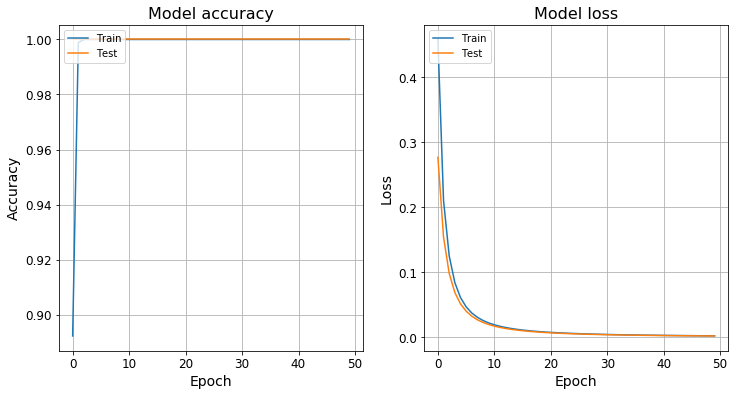

In [28]:
# Plotting results from history
plot_history(history)

## Performing LRP

In [29]:
import innvestigate
import innvestigate.utils as iutils

scaled_samples = Zscaler.transform(X_valid)

# Getting all the samples that can be correctly predicted
all_samples, _labels, correct_idxs = getCorrectPredictions(nn, scaled_samples, y_valid, enc = hot_encoder)
all_labels = y_valid_original[correct_idxs]


# Stripping the softmax activation from the model
model_w_softmax = nn
model = iutils.keras.graph.model_wo_softmax(model_w_softmax)

# Creating an analyzer
lrp_E = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPEpsilon(model=model, epsilon=1e-3)
lrp_Z = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZPlus(model=model)
lrp_AB   = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPAlpha2Beta1(model=model)

all_lrp_E = pd.DataFrame(lrp_E.analyze(all_samples))

Prediction Accuracy
2000/2000 [==============================] - 0s 10us/step
Scores on data set: loss=0.003 accuracy=1.0000


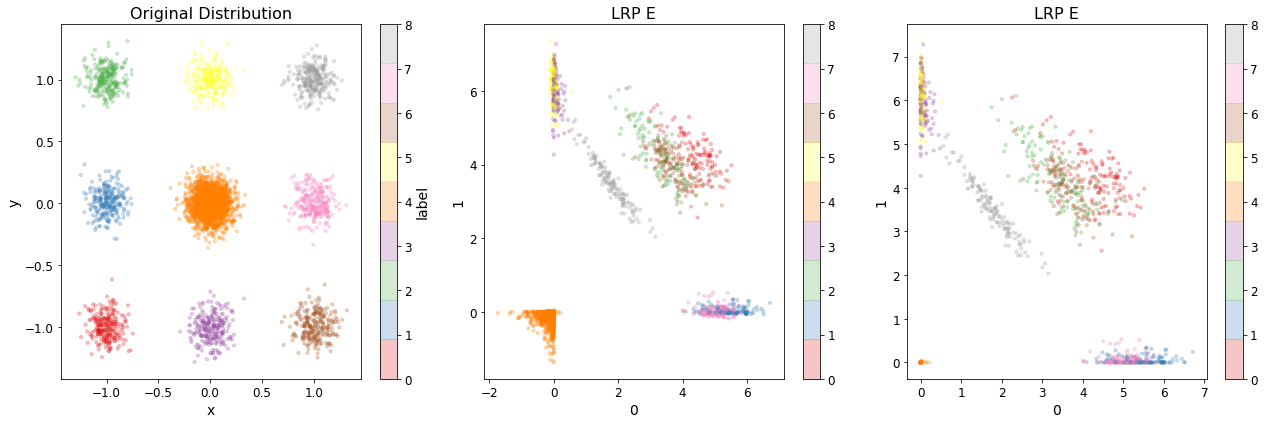

In [30]:
plt.close("Positive Only LRP")
fig, axs = plt.subplots(1,3, figsize=(18,6), num="Positive Only LRP")

cmap = "Set1" #"Paired"
plot_args = {"kind":"scatter", "x":0,  "y":1, "c":"label", "cmap": cmap, "s":10, "alpha":0.25}
original_data.plot(ax=axs[0],title="Original Distribution", **plot_args)

plot_args["c"] = all_labels
all_lrp_E.plot(ax=axs[1], title="LRP E", **plot_args)

pos_lrp = all_lrp_E.copy()
pos_lrp[pos_lrp<0] = 0
pos_lrp["label"] = all_labels.values
pos_lrp.plot(ax=axs[2],title="LRP E", **plot_args)

plt.tight_layout()
plt.show()

# Beginning Clustering using accelerated HDBSCAN*

In [37]:
import hdbscan
import seaborn as sns
from sklearn import metrics

%matplotlib inline
# sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

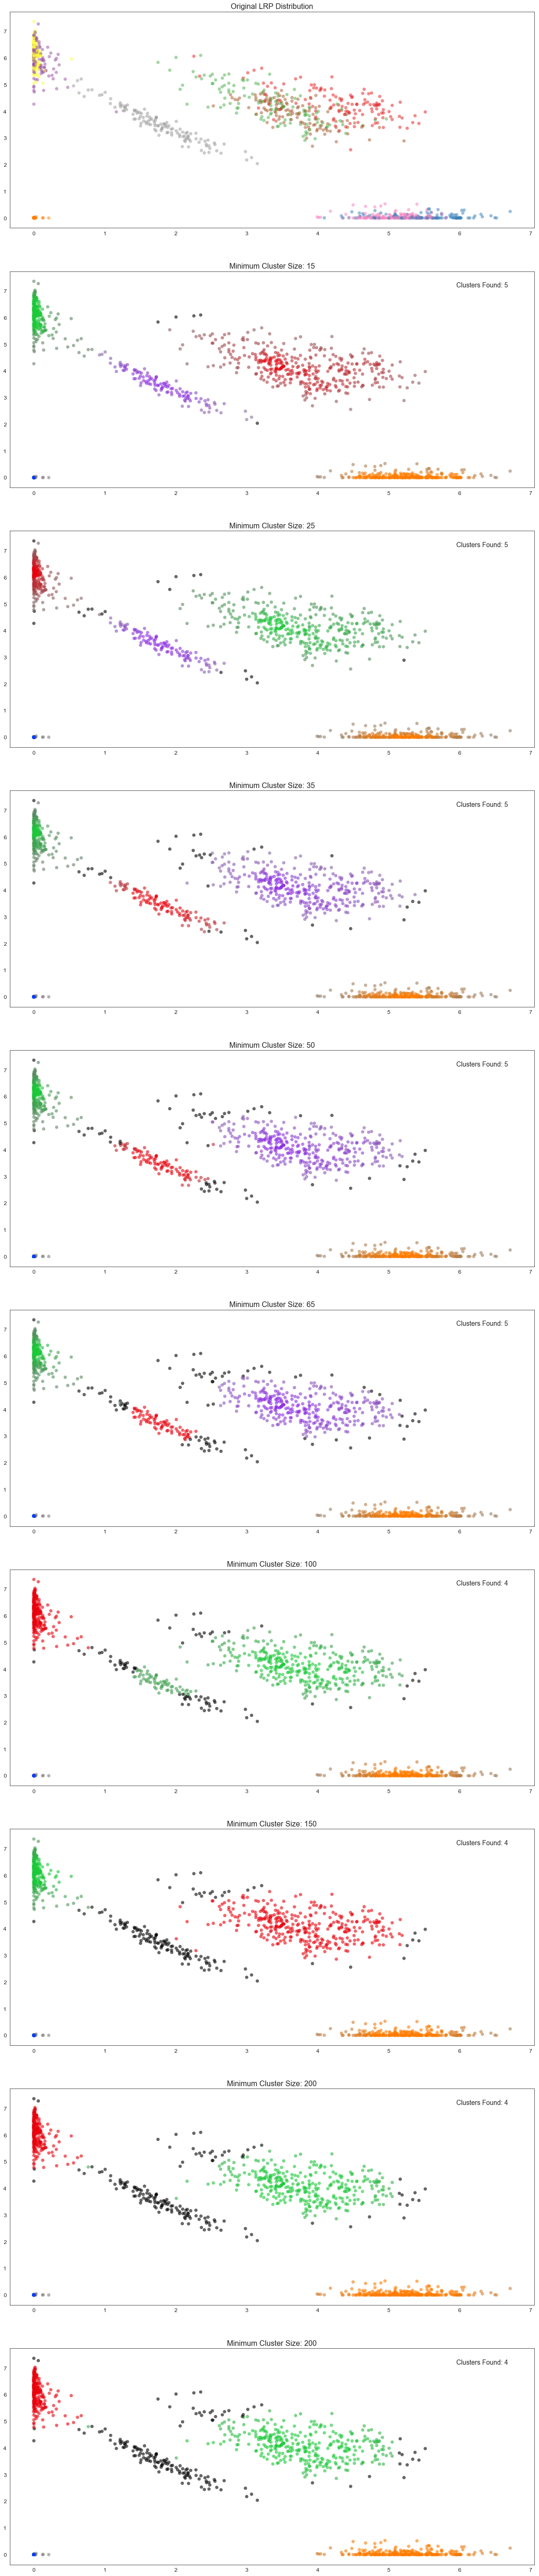

In [38]:
data = pos_lrp[[0,1]].values

cluster_sizes = [15,25,35,50,65,100,150,200,200]
plt.close("Cluster Comparison")
fig, axs = plt.subplots(1+len(cluster_sizes), 1, figsize=(20,10*(1+len(cluster_sizes))), num="Cluster Comparison")
plt.title("Cluster Comparison")


axs[0].scatter(*data.T, s=50, linewidth=0, c=pos_lrp["label"].values, alpha=0.5, cmap=plot_args["cmap"])
axs[0].set_title("Original LRP Distribution")


_metrics = []

for i,size in enumerate(cluster_sizes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    clusterer.fit(data)
    cluster_labels = clusterer.labels_
    
     ## Number of clusters in labels, ignoring noise if present.
    num_clusters = cluster_labels.max() + 1
    
    color_palette = sns.color_palette("bright", num_clusters)
    cluster_colors = [color_palette[x] if x >= 0
                      else (0, 0, 0)
                      for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, clusterer.probabilities_)]
    
    
    noise = list(cluster_labels).count(-1)/len(cluster_labels)
    hscore,cscore,vscore = metrics.homogeneity_completeness_v_measure(y_valid_original, cluster_labels)
    sil_score = metrics.silhouette_score(data, cluster_labels, metric="euclidean")
    
    _metrics.append([num_clusters,noise,sil_score,hscore,cscore,vscore])
    
    
    axs[i+1].scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.6)
    axs[i+1].set_title("Minimum Cluster Size: {}".format(size))
    axs[i+1].text(0.95,0.95,"Clusters Found: {}".format(num_clusters),
                horizontalalignment='right', verticalalignment='top',
                fontsize=14, transform=axs[i+1].transAxes)

# plt.tight_layout()
plt.show()

In [25]:
# plt.savefig(figures_dir+"clusters_desaturated.png")

# Plotting Clustering Performance

In [45]:
scores = pd.DataFrame(_metrics, columns=["Clusters", "Noise", "Silhouette", "Homogeneity", "Completeness", "V-Measure"], index=cluster_sizes)
sil_score_orig = metrics.silhouette_score(data, y_valid_original, metric="euclidean")
# scores["Silhouette"] = (sil_score_orig - scores["Silhouette"] ) / sil_score_orig
scores

,Clusters,Noise,Silhouette,Homogeneity,Completeness,V-Measure
15,5,0.0025,0.828415,0.770305,0.978541,0.862026
25,5,0.0100,0.829444,0.768599,0.961798,0.854413
35,5,0.0200,0.829105,0.766808,0.943308,0.845950
50,5,0.0330,0.820365,0.759955,0.923693,0.833862
65,5,0.0475,0.805757,0.755266,0.913189,0.826753
100,4,0.0410,0.785963,0.706948,0.924688,0.801290
150,4,0.0745,0.824592,0.750132,0.951853,0.839038
200,4,0.0815,0.818217,0.743833,0.940487,0.830680
200,4,0.0815,0.818217,0.743833,0.940487,0.830680


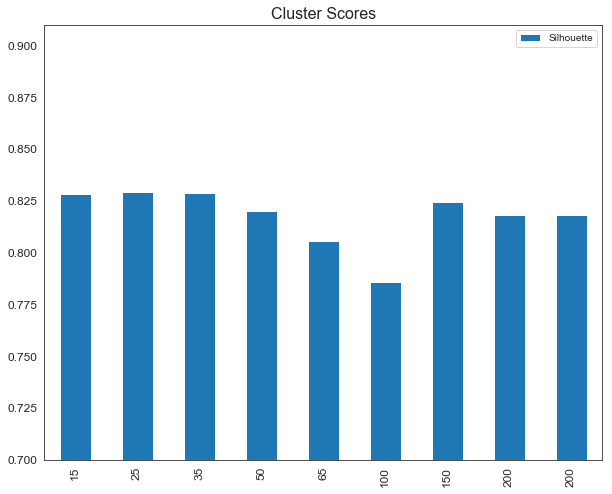

In [50]:
plt.close("Cluster Scores")
fig, axs = plt.subplots(figsize=(10,8), num="Cluster Scores")
plt.title("Cluster Scores")

scores[["Silhouette"]].plot(kind="bar", ax=axs, ylim=(0.7,.91))

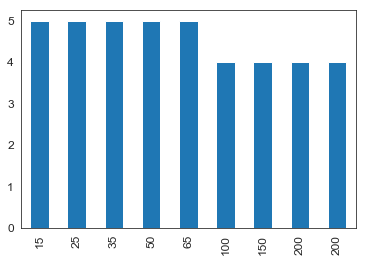

In [53]:
scores["Clusters"].plot(kind="bar")